In [2]:
import pandas as pd
import os
import torch
import numpy as np
import nltk
import string
from tqdm.notebook import tqdm

In [43]:
embed_size = 300
batch_size = 10

In [44]:
torch.manual_seed(0)

In [45]:
inputs = np.load('train_w2v_embeds.npy')

In [46]:
inputs.shape

(15716, 8, 300, 1)

In [47]:
inputs = np.transpose(inputs, (0, 3, 1, 2))
inputs.shape

(15716, 1, 8, 300)

In [48]:
labels = np.load('labels_train_embeds.npy')

In [49]:
labels = np.array([int(i) for i in labels], dtype = np.int64)

In [50]:
labels.shape

(15716,)

In [51]:
labels

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [52]:
inputs = torch.from_numpy(inputs)
inputs.shape

torch.Size([15716, 1, 8, 300])

In [53]:
labels = torch.LongTensor(labels)
labels.shape

torch.Size([15716])

In [54]:
dataset = torch.utils.data.TensorDataset(inputs, labels)

In [55]:
class RepEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (3, embed_size))
        self.relu = torch.nn.ReLU()
        self.dense1 = torch.nn.Linear(in_features = 64, out_features = 32)
        self.dense2 = torch.nn.Linear(in_features = 32, out_features = 4)
    
    def forward(self, inputs):
        out = self.conv(inputs)
        out = self.relu(out)
        out, indices = torch.max(out, 2)
        out = torch.flatten(out, start_dim = 1)
        out = self.dense1(out)
        out = self.relu(out)
        out = self.dense2(out)
        return out

In [56]:
def train(epochs, batch_size):
    model = RepEncoder()
    model.double()
    loss_fn = torch.nn.CrossEntropyLoss()
    dataset = torch.utils.data.TensorDataset(inputs, labels)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    loader = torch.utils.data.DataLoader(dataset, sampler = torch.utils.data.RandomSampler(dataset), batch_size = batch_size)
    for epoch in tqdm(range(epochs)):
        for idx, data in enumerate(loader):
            reqs, tgts = data
            tgts.type(torch.LongTensor)
            preds = model(reqs)
            loss = loss_fn(preds, tgts)
            model.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch}, loss: {loss}")
    torch.save(model.state_dict(), 'saved_model.pt')

In [57]:
train(50, 100)

Epoch: 0, loss: 1.3671565618130948
Epoch: 1, loss: 1.3361929894077218
Epoch: 2, loss: 1.3197086809254663
Epoch: 3, loss: 1.253296788987789
Epoch: 4, loss: 1.2466306342189215
Epoch: 5, loss: 1.2382913746464053
Epoch: 6, loss: 1.0588672534558758
Epoch: 7, loss: 1.1408583850672234
Epoch: 8, loss: 1.2143345878557894
Epoch: 9, loss: 1.312457037698266
Epoch: 10, loss: 1.050141476109752
Epoch: 11, loss: 1.1316208615437489
Epoch: 12, loss: 1.258680129415528
Epoch: 13, loss: 1.2937292803053717
Epoch: 14, loss: 1.531814173847142
Epoch: 15, loss: 1.0933267179470556
Epoch: 16, loss: 1.0179223120466259
Epoch: 17, loss: 0.8833790983937662
Epoch: 18, loss: 0.8281751972383632
Epoch: 19, loss: 1.017976530766756
Epoch: 20, loss: 0.939777539776028
Epoch: 21, loss: 0.8415563527102243
Epoch: 22, loss: 0.9150991844629538
Epoch: 23, loss: 0.9096332607708434
Epoch: 24, loss: 0.8083642412908172
Epoch: 25, loss: 0.8671712729698807
Epoch: 26, loss: 0.8588114800914205
Epoch: 27, loss: 0.8772214184713244
Epoch: 28

In [58]:
model = RepEncoder()
model.load_state_dict(torch.load('saved_model.pt'))
model.eval()

RepEncoder(
  (conv): Conv2d(1, 64, kernel_size=(3, 300), stride=(1, 1))
  (relu): ReLU()
  (dense1): Linear(in_features=64, out_features=32, bias=True)
  (dense2): Linear(in_features=32, out_features=4, bias=True)
)

In [59]:
dev_inputs = np.load('dev_w2v_embeds.npy')

In [60]:
dev_inputs.shape

(50, 7, 300)

In [61]:
dev_inputs = np.expand_dims(dev_inputs, axis = 3)
dev_inputs.shape

(50, 7, 300, 1)

In [62]:
dev_inputs = np.transpose(dev_inputs, (0, 3, 1, 2))
dev_inputs.shape

(50, 1, 7, 300)

In [63]:
model.double()
preds = model(torch.from_numpy(dev_inputs))

In [64]:
preds

tensor([[-1.0631e+00,  7.6729e-01,  4.9550e-01, -7.7233e-01],
        [-1.3433e+00,  1.5131e+00,  2.0179e-01, -1.7968e+00],
        [-1.1240e+00,  1.1044e+00,  2.6073e-01, -1.6164e+00],
        [-1.5883e+00,  8.4063e-01,  9.1070e-01, -7.9954e-01],
        [-1.4927e+00,  1.1253e+00,  8.2971e-01, -1.9206e+00],
        [-1.3973e-01,  4.3438e-01, -1.6506e-01, -8.1263e-01],
        [ 3.9577e-01,  5.7492e-01, -7.4396e-01, -1.0642e+00],
        [-4.2581e-01,  5.7152e-01, -1.1007e-02, -9.9951e-01],
        [-2.6316e-01,  2.3402e-01,  5.8323e-02, -3.1174e-01],
        [-2.8568e+00,  1.9775e+00,  1.3045e+00, -1.3823e+00],
        [-7.2947e-01,  7.1859e-01,  3.9244e-01, -1.3624e+00],
        [-1.6192e+00,  8.0183e-01,  1.0265e+00, -3.9517e-01],
        [-9.2522e-01,  1.2728e+00, -2.4016e-02, -1.3355e+00],
        [-8.9672e-01, -1.7453e-03,  9.9219e-01, -1.3682e-01],
        [-1.6901e+00,  1.2088e+00,  7.9764e-01, -1.4472e+00],
        [ 3.2122e-01,  2.6973e-01, -5.0066e-01, -9.0060e-01],
        

In [65]:
class_preds = np.argmax(preds.detach().numpy(), axis = 1)

In [72]:
class_preds

array([2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3,
       2, 2, 3, 2, 2, 2], dtype=int64)

In [67]:
class_preds = class_preds + 1
class_preds

array([2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 1, 3, 2, 3, 2, 2, 3,
       3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 1, 2, 2, 1, 2, 2, 2, 2, 2, 3, 3, 2,
       3, 2, 3, 3, 1, 2], dtype=int64)

In [247]:
dev_ids = np.load('topics_dev.npy')
dev_ids

array(['101', '106', '107', '114', '123', '128', '133', '139', '142',
       '164', '165', '166', '169', '174', '18', '190', '191', '193',
       '195', '200', '24', '25', '27', '35', '37', '45', '71', '74', '8',
       '85', '214', '219', '229', '250', '252', '262', '283', '287',
       '293', '110', '118', '126', '152', '20', '44', '51', '79', '83',
       '256', '292'], dtype='<U77')

In [248]:
outs = [(dev_ids[i], class_preds[i]) for i in range(len(preds))]
outs

[('101', 2),
 ('106', 2),
 ('107', 2),
 ('114', 3),
 ('123', 2),
 ('128', 2),
 ('133', 1),
 ('139', 2),
 ('142', 2),
 ('164', 2),
 ('165', 2),
 ('166', 3),
 ('169', 2),
 ('174', 3),
 ('18', 2),
 ('190', 2),
 ('191', 3),
 ('193', 2),
 ('195', 2),
 ('200', 2),
 ('24', 2),
 ('25', 3),
 ('27', 4),
 ('35', 3),
 ('37', 2),
 ('45', 2),
 ('71', 2),
 ('74', 4),
 ('8', 2),
 ('85', 2),
 ('214', 2),
 ('219', 3),
 ('229', 1),
 ('250', 2),
 ('252', 2),
 ('262', 1),
 ('283', 2),
 ('287', 2),
 ('293', 2),
 ('110', 1),
 ('118', 2),
 ('126', 3),
 ('152', 2),
 ('20', 2),
 ('44', 4),
 ('51', 2),
 ('79', 2),
 ('83', 3),
 ('256', 1),
 ('292', 2)]

In [249]:
outs = np.array(outs)
outs

array([['101', '2'],
       ['106', '2'],
       ['107', '2'],
       ['114', '3'],
       ['123', '2'],
       ['128', '2'],
       ['133', '1'],
       ['139', '2'],
       ['142', '2'],
       ['164', '2'],
       ['165', '2'],
       ['166', '3'],
       ['169', '2'],
       ['174', '3'],
       ['18', '2'],
       ['190', '2'],
       ['191', '3'],
       ['193', '2'],
       ['195', '2'],
       ['200', '2'],
       ['24', '2'],
       ['25', '3'],
       ['27', '4'],
       ['35', '3'],
       ['37', '2'],
       ['45', '2'],
       ['71', '2'],
       ['74', '4'],
       ['8', '2'],
       ['85', '2'],
       ['214', '2'],
       ['219', '3'],
       ['229', '1'],
       ['250', '2'],
       ['252', '2'],
       ['262', '1'],
       ['283', '2'],
       ['287', '2'],
       ['293', '2'],
       ['110', '1'],
       ['118', '2'],
       ['126', '3'],
       ['152', '2'],
       ['20', '2'],
       ['44', '4'],
       ['51', '2'],
       ['79', '2'],
       ['83', '3'],
       ['

In [250]:
np.savetxt('preds_dev_w2v_augmented.txt', outs, fmt="%s %s")

In [15]:
from sklearn.metrics import confusion_matrix

In [73]:
labels = np.load('labels_dev_embeds.npy')

In [79]:
labels

array([2, 3, 3, 2, 3, 2, 2, 2, 2, 4, 3, 3, 4, 4, 2, 2, 2, 3, 2, 3, 4, 4,
       3, 3, 3, 2, 3, 3, 4, 3, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 4,
       2, 2, 4, 4, 1, 3])

In [22]:
class_preds = [3,3,3,1,3,4,2,3,2,2,3,2,3,3,3,4,4,3,3,3,3,3,2,3,3,3,3,3,3,3,3,3,3,2,3,2,2,3,3,2,3,3,2,3,3,1,3,3,4,3]


In [23]:
class_preds = np.array(class_preds)

In [68]:
class_preds

array([2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 1, 3, 2, 3, 2, 2, 3,
       3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 1, 2, 2, 1, 2, 2, 2, 2, 2, 3, 3, 2,
       3, 2, 3, 3, 1, 2], dtype=int64)

In [94]:
class_preds = np.load('classpreds_model_1_dev.npy')

In [95]:
class_preds

array([2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3,
       2, 2, 3, 2, 2, 2], dtype=int64)

In [75]:
cf_matrix = confusion_matrix(labels, class_preds)
print(cf_matrix)

[[ 0  4  0  0]
 [ 0 16  4  1]
 [ 0 15  1  0]
 [ 0  5  4  0]]


In [77]:
cf_matrix = [[2,1,1,0], [2,13,6,0], [0,9,7,0], [0,5,4,0]]

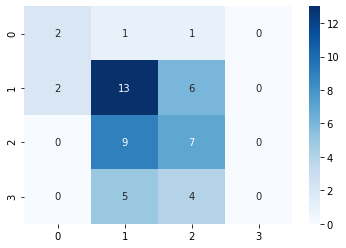

In [78]:
import seaborn as sns
sns.heatmap(cf_matrix, cmap = "Blues", annot = True)

In [14]:
class_preds

[3,
 3,
 3,
 1,
 3,
 4,
 2,
 3,
 2,
 2,
 3,
 2,
 3,
 3,
 3,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 2,
 2,
 3,
 3,
 2,
 3,
 3,
 2,
 3,
 3,
 1,
 3,
 3,
 4,
 3]

In [7]:
labels

array([2, 3, 3, 2, 3, 2, 2, 2, 2, 4, 3, 3, 4, 4, 2, 2, 2, 3, 2, 3, 4, 4,
       3, 3, 3, 2, 3, 3, 4, 3, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 4,
       2, 2, 4, 4, 1, 3])

In [8]:
np.histogram(labels, bins = [1,2,3,4,5])

(array([ 4, 21, 16,  9], dtype=int64), array([1, 2, 3, 4, 5]))

In [2]:
import matplotlib.pyplot as plt

In [3]:
matrix = [[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.14986621, 0.17987404, 0.34463639,
        0.31209697, 0.29068076, 0.36490785, 0.38398051, 0.        ,
        0.33238697, 0.26860541, 0.        , 0.50913671, 0.        ,
        0.16449525, 0.04373682, 0.        , 0.30425273, 0.        ],
       [0.        , 0.14986621, 1.        , 0.06531242, 0.13567848,
        0.12977611, 0.08418215, 0.08870296, 0.15283304, 0.        ,
        0.10370234, 0.07403679, 0.        , 0.17994761, 0.        ,
        0.09528971, 0.03799583, 0.        , 0.07508937, 0.        ],
       [0.        , 0.17987404, 0.06531242, 1.        , 0.27398639,
        0.27399229, 0.2105554 , 0.20829149, 0.28312531, 0.        ,
        0.25885677, 0.16551455, 0.        , 0.34509535, 0.        ,
        0.09854718, 0.02425784, 0.        , 0.19057303, 0.        ],
       [0.        , 0.34463639, 0.13567848, 0.27398639, 1.        ,
        0.36696684, 0.33539028, 0.36562416, 0.49178689, 0.        ,
        0.47634421, 0.38037895, 0.        , 0.60768503, 0.        ,
        0.18568641, 0.04687261, 0.        , 0.31622511, 0.        ],
       [0.        , 0.31209697, 0.12977611, 0.27399229, 0.36696684,
        1.        , 0.33186311, 0.38356609, 0.4773788 , 0.        ,
        0.36294259, 0.25630784, 0.        , 0.6102883 , 0.        ,
        0.165247  , 0.05755187, 0.        , 0.28602651, 0.        ],
       [0.        , 0.29068076, 0.08418215, 0.2105554 , 0.33539028,
        0.33186311, 1.        , 0.31127243, 0.43481823, 0.        ,
        0.32469232, 0.23142705, 0.        , 0.50609804, 0.        ,
        0.1359846 , 0.05010383, 0.        , 0.25329075, 0.        ],
       [0.        , 0.36490785, 0.08870296, 0.20829149, 0.36562416,
        0.38356609, 0.31127243, 1.        , 0.41807527, 0.        ,
        0.35214096, 0.27531835, 0.        , 0.54369978, 0.        ,
        0.13514729, 0.04883558, 0.        , 0.57648255, 0.        ],
       [0.        , 0.38398051, 0.15283304, 0.28312531, 0.49178689,
        0.4773788 , 0.43481823, 0.41807527, 1.        , 0.        ,
        0.47087656, 0.34596379, 0.        , 0.78880637, 0.        ,
        0.22008694, 0.07528506, 0.        , 0.34842617, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.33238697, 0.10370234, 0.25885677, 0.47634421,
        0.36294259, 0.32469232, 0.35214096, 0.47087656, 0.        ,
        1.        , 0.28946766, 0.        , 0.56157489, 0.        ,
        0.16639139, 0.05201116, 0.        , 0.29163908, 0.        ],
       [0.        , 0.26860541, 0.07403679, 0.16551455, 0.38037895,
        0.25630784, 0.23142705, 0.27531835, 0.34596379, 0.        ,
        0.28946766, 1.        , 0.        , 0.41356797, 0.        ,
        0.12769789, 0.03928067, 0.        , 0.24099778, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.50913671, 0.17994761, 0.34509535, 0.60768503,
        0.6102883 , 0.50609804, 0.54369978, 0.78880637, 0.        ,
        0.56157489, 0.41356797, 0.        , 1.        , 0.        ,
        0.25035692, 0.07908807, 0.        , 0.42201755, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.16449525, 0.09528971, 0.09854718, 0.18568641,
        0.165247  , 0.1359846 , 0.13514729, 0.22008694, 0.        ,
        0.16639139, 0.12769789, 0.        , 0.25035692, 0.        ,
        1.        , 0.02075175, 0.        , 0.12075924, 0.        ],
       [0.        , 0.04373682, 0.03799583, 0.02425784, 0.04687261,
        0.05755187, 0.05010383, 0.04883558, 0.07528506, 0.        ,
        0.05201116, 0.03928067, 0.        , 0.07908807, 0.        ,
        0.02075175, 1.        , 0.        , 0.04148338, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.30425273, 0.07508937, 0.19057303, 0.31622511,
        0.28602651, 0.25329075, 0.57648255, 0.34842617, 0.        ,
        0.29163908, 0.24099778, 0.        , 0.42201755, 0.        ,
        0.12075924, 0.04148338, 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]]

In [22]:
matrix = np.array(matrix)+np.eye(len(matrix))

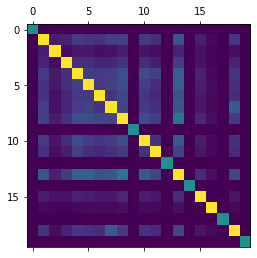

In [23]:
plt.matshow(matrix)

In [4]:
matrix1 = [[1.0000, 0.9980, 0.9976, 0.9975, 0.9978, 0.9974, 0.9976, 0.9971, 0.9974,
         0.9977, 0.9978, 0.9978, 0.9979, 0.9980, 0.9978, 0.9980, 0.9979, 0.9980,
         0.9980, 0.9979],
        [0.9980, 1.0000, 0.9973, 0.9974, 0.9977, 0.9970, 0.9975, 0.9975, 0.9970,
         0.9975, 0.9977, 0.9976, 0.9982, 0.9980, 0.9980, 0.9979, 0.9979, 0.9977,
         0.9978, 0.9977],
        [0.9976, 0.9973, 1.0001, 0.9980, 0.9980, 0.9974, 0.9978, 0.9967, 0.9973,
         0.9981, 0.9982, 0.9979, 0.9978, 0.9981, 0.9980, 0.9982, 0.9984, 0.9983,
         0.9981, 0.9979],
        [0.9975, 0.9974, 0.9980, 1.0000, 0.9982, 0.9975, 0.9979, 0.9967, 0.9974,
         0.9979, 0.9982, 0.9982, 0.9976, 0.9983, 0.9979, 0.9980, 0.9982, 0.9981,
         0.9983, 0.9978],
        [0.9978, 0.9977, 0.9980, 0.9982, 1.0000, 0.9979, 0.9979, 0.9969, 0.9976,
         0.9982, 0.9982, 0.9980, 0.9978, 0.9983, 0.9982, 0.9983, 0.9983, 0.9983,
         0.9983, 0.9978],
        [0.9974, 0.9970, 0.9974, 0.9975, 0.9979, 1.0000, 0.9978, 0.9961, 0.9972,
         0.9977, 0.9978, 0.9977, 0.9973, 0.9979, 0.9978, 0.9977, 0.9977, 0.9977,
         0.9977, 0.9974],
        [0.9976, 0.9975, 0.9978, 0.9979, 0.9979, 0.9978, 1.0000, 0.9968, 0.9975,
         0.9979, 0.9981, 0.9978, 0.9974, 0.9984, 0.9981, 0.9983, 0.9982, 0.9983,
         0.9980, 0.9979],
        [0.9971, 0.9975, 0.9967, 0.9967, 0.9969, 0.9961, 0.9968, 1.0000, 0.9965,
         0.9971, 0.9969, 0.9970, 0.9973, 0.9972, 0.9972, 0.9973, 0.9973, 0.9970,
         0.9970, 0.9967],
        [0.9974, 0.9970, 0.9973, 0.9974, 0.9976, 0.9972, 0.9975, 0.9965, 0.9999,
         0.9978, 0.9975, 0.9976, 0.9972, 0.9977, 0.9975, 0.9978, 0.9976, 0.9976,
         0.9976, 0.9969],
        [0.9977, 0.9975, 0.9981, 0.9979, 0.9982, 0.9977, 0.9979, 0.9971, 0.9978,
         0.9999, 0.9982, 0.9982, 0.9977, 0.9984, 0.9981, 0.9985, 0.9984, 0.9984,
         0.9981, 0.9978],
        [0.9978, 0.9977, 0.9982, 0.9982, 0.9982, 0.9978, 0.9981, 0.9969, 0.9975,
         0.9982, 1.0000, 0.9982, 0.9981, 0.9982, 0.9981, 0.9984, 0.9984, 0.9984,
         0.9985, 0.9980],
        [0.9978, 0.9976, 0.9979, 0.9982, 0.9980, 0.9977, 0.9978, 0.9970, 0.9976,
         0.9982, 0.9982, 1.0000, 0.9975, 0.9981, 0.9982, 0.9983, 0.9982, 0.9982,
         0.9983, 0.9979],
        [0.9979, 0.9982, 0.9978, 0.9976, 0.9978, 0.9973, 0.9974, 0.9973, 0.9972,
         0.9977, 0.9981, 0.9975, 1.0000, 0.9980, 0.9977, 0.9981, 0.9978, 0.9978,
         0.9979, 0.9981],
        [0.9980, 0.9980, 0.9981, 0.9983, 0.9983, 0.9979, 0.9984, 0.9972, 0.9977,
         0.9984, 0.9982, 0.9981, 0.9980, 1.0000, 0.9984, 0.9987, 0.9987, 0.9988,
         0.9987, 0.9981],
        [0.9978, 0.9980, 0.9980, 0.9979, 0.9982, 0.9978, 0.9981, 0.9972, 0.9975,
         0.9981, 0.9981, 0.9982, 0.9977, 0.9984, 1.0000, 0.9984, 0.9983, 0.9982,
         0.9983, 0.9979],
        [0.9980, 0.9979, 0.9982, 0.9980, 0.9983, 0.9977, 0.9983, 0.9973, 0.9978,
         0.9985, 0.9984, 0.9983, 0.9981, 0.9987, 0.9984, 1.0000, 0.9986, 0.9987,
         0.9985, 0.9982],
        [0.9979, 0.9979, 0.9984, 0.9982, 0.9983, 0.9977, 0.9982, 0.9973, 0.9976,
         0.9984, 0.9984, 0.9982, 0.9978, 0.9987, 0.9983, 0.9986, 1.0000, 0.9987,
         0.9987, 0.9981],
        [0.9980, 0.9977, 0.9983, 0.9981, 0.9983, 0.9977, 0.9983, 0.9970, 0.9976,
         0.9984, 0.9984, 0.9982, 0.9978, 0.9988, 0.9982, 0.9987, 0.9987, 1.0000,
         0.9987, 0.9983],
        [0.9980, 0.9978, 0.9981, 0.9983, 0.9983, 0.9977, 0.9980, 0.9970, 0.9976,
         0.9981, 0.9985, 0.9983, 0.9979, 0.9987, 0.9983, 0.9985, 0.9987, 0.9987,
         1.0000, 0.9980],
        [0.9979, 0.9977, 0.9979, 0.9978, 0.9978, 0.9974, 0.9979, 0.9967, 0.9969,
         0.9978, 0.9980, 0.9979, 0.9981, 0.9981, 0.9979, 0.9982, 0.9981, 0.9983,
         0.9980, 1.0000]]

In [5]:
matrix1

[[1.0,
  0.998,
  0.9976,
  0.9975,
  0.9978,
  0.9974,
  0.9976,
  0.9971,
  0.9974,
  0.9977,
  0.9978,
  0.9978,
  0.9979,
  0.998,
  0.9978,
  0.998,
  0.9979,
  0.998,
  0.998,
  0.9979],
 [0.998,
  1.0,
  0.9973,
  0.9974,
  0.9977,
  0.997,
  0.9975,
  0.9975,
  0.997,
  0.9975,
  0.9977,
  0.9976,
  0.9982,
  0.998,
  0.998,
  0.9979,
  0.9979,
  0.9977,
  0.9978,
  0.9977],
 [0.9976,
  0.9973,
  1.0001,
  0.998,
  0.998,
  0.9974,
  0.9978,
  0.9967,
  0.9973,
  0.9981,
  0.9982,
  0.9979,
  0.9978,
  0.9981,
  0.998,
  0.9982,
  0.9984,
  0.9983,
  0.9981,
  0.9979],
 [0.9975,
  0.9974,
  0.998,
  1.0,
  0.9982,
  0.9975,
  0.9979,
  0.9967,
  0.9974,
  0.9979,
  0.9982,
  0.9982,
  0.9976,
  0.9983,
  0.9979,
  0.998,
  0.9982,
  0.9981,
  0.9983,
  0.9978],
 [0.9978,
  0.9977,
  0.998,
  0.9982,
  1.0,
  0.9979,
  0.9979,
  0.9969,
  0.9976,
  0.9982,
  0.9982,
  0.998,
  0.9978,
  0.9983,
  0.9982,
  0.9983,
  0.9983,
  0.9983,
  0.9983,
  0.9978],
 [0.9974,
  0.997,
  0.9

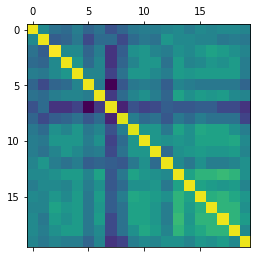

In [9]:
plt.matshow(matrix1)

In [10]:
plt.colorbar()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 432x288 with 0 Axes>

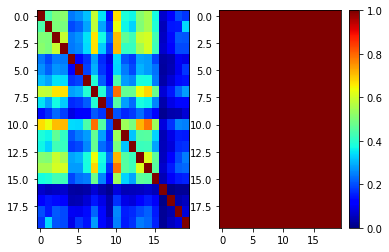

In [13]:
plt.subplot(1, 2, 1)
plt.imshow(matrix, vmin=0, vmax=1, cmap='jet', aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(matrix1, vmin=0, vmax=1, cmap='jet', aspect='auto')
plt.colorbar()

<ipython-input-11-32f253cf7970>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = figure.add_subplot(111)


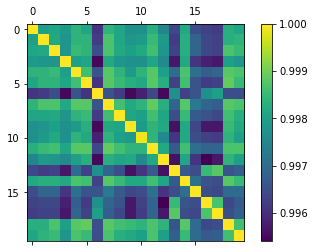

In [11]:
figure = plt.figure()
axes = figure.add_subplot(111)
ax2 = figure.add_subplot(111)
# using the matshow() function 
caxes = axes.matshow(matrix1)
figure.colorbar(caxes)


In [7]:
matrix1 = [[1.0000, 0.9980, 0.9981, 0.9979, 0.9984, 0.9981, 0.9961, 0.9984, 0.9981,
         0.9977, 0.9977, 0.9983, 0.9975, 0.9964, 0.9982, 0.9965, 0.9963, 0.9962,
         0.9983, 0.9981],
        [0.9980, 1.0000, 0.9982, 0.9978, 0.9984, 0.9984, 0.9962, 0.9987, 0.9981,
         0.9978, 0.9979, 0.9985, 0.9979, 0.9962, 0.9983, 0.9969, 0.9964, 0.9963,
         0.9983, 0.9984],
        [0.9981, 0.9982, 1.0000, 0.9978, 0.9985, 0.9984, 0.9965, 0.9987, 0.9982,
         0.9980, 0.9982, 0.9986, 0.9978, 0.9963, 0.9983, 0.9969, 0.9964, 0.9963,
         0.9987, 0.9985],
        [0.9979, 0.9978, 0.9978, 1.0000, 0.9980, 0.9981, 0.9955, 0.9982, 0.9978,
         0.9977, 0.9977, 0.9981, 0.9976, 0.9957, 0.9982, 0.9961, 0.9958, 0.9957,
         0.9980, 0.9978],
        [0.9984, 0.9984, 0.9985, 0.9980, 1.0000, 0.9986, 0.9966, 0.9988, 0.9984,
         0.9979, 0.9984, 0.9988, 0.9980, 0.9970, 0.9987, 0.9971, 0.9968, 0.9969,
         0.9988, 0.9987],
        [0.9981, 0.9984, 0.9984, 0.9981, 0.9986, 1.0000, 0.9961, 0.9988, 0.9985,
         0.9983, 0.9982, 0.9988, 0.9983, 0.9963, 0.9986, 0.9966, 0.9962, 0.9963,
         0.9989, 0.9985],
        [0.9961, 0.9962, 0.9965, 0.9955, 0.9966, 0.9961, 1.0000, 0.9966, 0.9962,
         0.9955, 0.9958, 0.9964, 0.9955, 0.9977, 0.9963, 0.9966, 0.9977, 0.9980,
         0.9965, 0.9965],
        [0.9984, 0.9987, 0.9987, 0.9982, 0.9988, 0.9988, 0.9966, 1.0000, 0.9986,
         0.9982, 0.9984, 0.9989, 0.9983, 0.9969, 0.9988, 0.9973, 0.9969, 0.9968,
         0.9988, 0.9987],
        [0.9981, 0.9981, 0.9982, 0.9978, 0.9984, 0.9985, 0.9962, 0.9986, 1.0000,
         0.9981, 0.9980, 0.9986, 0.9981, 0.9965, 0.9985, 0.9967, 0.9966, 0.9964,
         0.9986, 0.9983],
        [0.9977, 0.9978, 0.9980, 0.9977, 0.9979, 0.9983, 0.9955, 0.9982, 0.9981,
         1.0000, 0.9979, 0.9984, 0.9982, 0.9956, 0.9982, 0.9964, 0.9957, 0.9957,
         0.9985, 0.9982],
        [0.9977, 0.9979, 0.9982, 0.9977, 0.9984, 0.9982, 0.9958, 0.9984, 0.9980,
         0.9979, 0.9999, 0.9984, 0.9976, 0.9961, 0.9982, 0.9965, 0.9963, 0.9962,
         0.9984, 0.9980],
        [0.9983, 0.9985, 0.9986, 0.9981, 0.9988, 0.9988, 0.9964, 0.9989, 0.9986,
         0.9984, 0.9984, 1.0000, 0.9982, 0.9967, 0.9986, 0.9971, 0.9969, 0.9969,
         0.9987, 0.9987],
        [0.9975, 0.9979, 0.9978, 0.9976, 0.9980, 0.9983, 0.9955, 0.9983, 0.9981,
         0.9982, 0.9976, 0.9982, 1.0000, 0.9956, 0.9981, 0.9961, 0.9954, 0.9957,
         0.9984, 0.9980],
        [0.9964, 0.9962, 0.9963, 0.9957, 0.9970, 0.9963, 0.9977, 0.9969, 0.9965,
         0.9956, 0.9961, 0.9967, 0.9956, 1.0000, 0.9967, 0.9965, 0.9985, 0.9988,
         0.9966, 0.9968],
        [0.9982, 0.9983, 0.9983, 0.9982, 0.9987, 0.9986, 0.9963, 0.9988, 0.9985,
         0.9982, 0.9982, 0.9986, 0.9981, 0.9967, 1.0000, 0.9971, 0.9966, 0.9965,
         0.9988, 0.9985],
        [0.9965, 0.9969, 0.9969, 0.9961, 0.9971, 0.9966, 0.9966, 0.9973, 0.9967,
         0.9964, 0.9965, 0.9971, 0.9961, 0.9965, 0.9971, 1.0000, 0.9965, 0.9964,
         0.9970, 0.9970],
        [0.9963, 0.9964, 0.9964, 0.9958, 0.9968, 0.9962, 0.9977, 0.9969, 0.9966,
         0.9957, 0.9963, 0.9969, 0.9954, 0.9985, 0.9966, 0.9965, 1.0000, 0.9987,
         0.9964, 0.9967],
        [0.9962, 0.9963, 0.9963, 0.9957, 0.9969, 0.9963, 0.9980, 0.9968, 0.9964,
         0.9957, 0.9962, 0.9969, 0.9957, 0.9988, 0.9965, 0.9964, 0.9987, 1.0000,
         0.9965, 0.9968],
        [0.9983, 0.9983, 0.9987, 0.9980, 0.9988, 0.9989, 0.9965, 0.9988, 0.9986,
         0.9985, 0.9984, 0.9987, 0.9984, 0.9966, 0.9988, 0.9970, 0.9964, 0.9965,
         1.0000, 0.9986],
        [0.9981, 0.9984, 0.9985, 0.9978, 0.9987, 0.9985, 0.9965, 0.9987, 0.9983,
         0.9982, 0.9980, 0.9987, 0.9980, 0.9968, 0.9985, 0.9970, 0.9967, 0.9968,
         0.9986, 1.0000]]

In [8]:
matrix1

[[1.0,
  0.998,
  0.9981,
  0.9979,
  0.9984,
  0.9981,
  0.9961,
  0.9984,
  0.9981,
  0.9977,
  0.9977,
  0.9983,
  0.9975,
  0.9964,
  0.9982,
  0.9965,
  0.9963,
  0.9962,
  0.9983,
  0.9981],
 [0.998,
  1.0,
  0.9982,
  0.9978,
  0.9984,
  0.9984,
  0.9962,
  0.9987,
  0.9981,
  0.9978,
  0.9979,
  0.9985,
  0.9979,
  0.9962,
  0.9983,
  0.9969,
  0.9964,
  0.9963,
  0.9983,
  0.9984],
 [0.9981,
  0.9982,
  1.0,
  0.9978,
  0.9985,
  0.9984,
  0.9965,
  0.9987,
  0.9982,
  0.998,
  0.9982,
  0.9986,
  0.9978,
  0.9963,
  0.9983,
  0.9969,
  0.9964,
  0.9963,
  0.9987,
  0.9985],
 [0.9979,
  0.9978,
  0.9978,
  1.0,
  0.998,
  0.9981,
  0.9955,
  0.9982,
  0.9978,
  0.9977,
  0.9977,
  0.9981,
  0.9976,
  0.9957,
  0.9982,
  0.9961,
  0.9958,
  0.9957,
  0.998,
  0.9978],
 [0.9984,
  0.9984,
  0.9985,
  0.998,
  1.0,
  0.9986,
  0.9966,
  0.9988,
  0.9984,
  0.9979,
  0.9984,
  0.9988,
  0.998,
  0.997,
  0.9987,
  0.9971,
  0.9968,
  0.9969,
  0.9988,
  0.9987],
 [0.9981,
  0.9984